### Business Problem

Telecom Inc., an American telecomunications company, is competing with a an up-start company that has eaten into their majority market share in recent years. To re-gain their market share, Telecom Inc. must first address the issue of customer churn. Telecom Inc. needs a model to help them predict which of customers are likely to churn to they can intervene and save the accounts. They also want to know what factors contribute to churn so they can improve their service to prevent future churn.

To evaluate the preformance of their customer churn model, Telecom Inc. will use F1 score because the firm wants to  capture true positives but is also concerned about minimizing false negatives and false positives. False positives are costly because in cases where our model predicts a customer will churn, Telecom Inc. intends to intervene with customer support and discounts. Given the class imbalence (81%), F1 score does a better job evaluating the true performance of our model.

#### To-do

#### Imports

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier

#Import data
df = pd.read_csv("data/cleaned_data.csv",index_col=0)

#New imports for our Pipeline workflows
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

#### Select target and features

In [2]:
X = df.drop(columns=["churn","phone number"])
y = df['churn']

#### Train test split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=20)

#### Build a dummy model

In [4]:
#Imports
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
from sklearn.dummy import DummyClassifier

In [5]:
#Build our dummy model
Dummy_model = DummyClassifier(strategy="constant",constant=1)
Dummy_model.fit(X=X_train,y=y_train)
Dummy_model_pred = Dummy_model.predict(X_train)

In [6]:
#define a function to score our model
def model_results(model,X_train,y_train):
    plot_confusion_matrix(estimator=model,X=X_train,y_true=y_train)
    plot_roc_curve(estimator=model,X=X_train,y=y_train)
    print(f'Avg f1 score {np.mean(cross_val_score(estimator=model,X=X_train,y=y_train,cv=5,scoring="f1"))}')
    print(f'f1 cross validation scores {cross_val_score(estimator=model,X=X_train,y=y_train,cv=5,scoring="f1")}')

Avg f1 score 0.255047439480117
f1 cross validation scores [0.25420561 0.25420561 0.25746269 0.25468165 0.25468165]


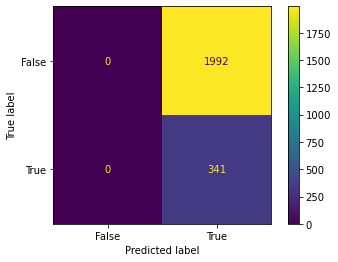

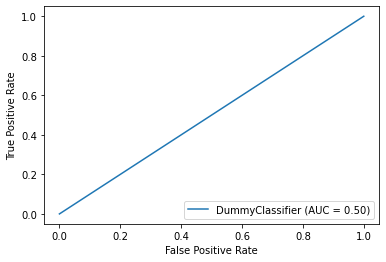

In [7]:
#Score our dummy model
model_results(model=Dummy_model,X_train=X_train,y_train=y_train)

### Decision Tree 1.0
- Weighted avg f1 score: 0.938
- Major improvement from simple model
- We included all our features but many of them had no impact on our results so the next step is to peform another grid search but with just the top 10 features based on feature importance
- We have more false negatives than I'd like, maybe this can be addressed later with SMOTE

#### Build column transformer and pipeline

In [8]:
#Identify numeric columns for scaling
num_columns = list(df.select_dtypes(include=['float', 'int']).columns.drop('area code'))
#Instantiate column transformer
CT_ord = ColumnTransformer(transformers=[
    ("num_columns",StandardScaler(),num_columns),
    ("ohe",OneHotEncoder(sparse=False,handle_unknown="ignore"),["state","area code"]),    
    ("ord",OrdinalEncoder(),['international plan','voice mail plan'])
    ]
    )

In [9]:
#Instantiate a pipeline including the Decision Tree and one without the Decision Tree
#With Decision Tree
DT_Pipeline_ord = Pipeline([
    ("CT",CT_ord),
    ("estimator",DecisionTreeClassifier(random_state=42))
])
#Without Decision Tree, used for transforming
Pipeline_ord_trans = Pipeline([
    ("CT",CT_ord),
])

#### Grid search params

In [10]:
#Create grid search grid, instantiate grid search, and fit to train data
param_grid_pipeline = {'estimator__criterion':['gini','entropy'],'estimator__max_depth':[None,5,6,7,8],'estimator__min_samples_leaf':[1,5,10],'estimator__max_features':[None,10,20,30]}

#### Model fitting

In [11]:
#Fit our model
GS_ord = GridSearchCV(estimator=DT_Pipeline_ord,param_grid=param_grid_pipeline,scoring="f1_weighted",cv=5)
GS_ord.fit(X=X_train,y=y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(transformers=[('num_columns',
                                                                         StandardScaler(),
                                                                         ['account '
                                                                          'length',
                                                                          'number '
                                                                          'vmail '
                                                                          'messages',
                                                                          'total '
                                                                          'day '
                                                                          'minutes',
                                                                          'total '
  

#### Model evaluation

In [ ]:
#Best feature combination
GS_ord.best_params_

In [ ]:
#To create a readible print of our feature importances we need to collate feature names from various places and pass into a dataframe
ohe_column_names = list(GS_ord.best_estimator_.named_steps.CT.named_transformers_.ohe.get_feature_names())
feature_names = num_columns
feature_names.extend(ohe_column_names)
feature_names.extend(['international plan','voice mail plan'])

In [ ]:
#Put feature importance values into dataframe and sort values by feature importance
feature_importance_df = pd.DataFrame(data=GS_ord.best_estimator_.named_steps.estimator.feature_importances_,index=feature_names,columns=["feature importance"])
feature_importances_sorted = feature_importance_df.sort_values(by='feature importance',ascending=False).head(10)
feature_importances_sorted.to_csv('data/feature_importances.csv')
feature_importances_sorted

In [12]:
#Re-define the function to score our model to accomidate grid search
def gs_model_results(model,X_train,y_train):
    plot_confusion_matrix(estimator=model,X=X_train,y_true=y_train)
    plot_roc_curve(estimator=model,X=X_train,y=y_train)
    print(f'Weighted avg f1 score: {round(model.best_score_,3)}')
    print()
    print(f'Split 1 f1 score: {round(model.cv_results_["split0_test_score"][model.best_index_],3)}')
    print(f'Split 2 f1 score: {round(model.cv_results_["split1_test_score"][model.best_index_],3)}')
    print(f'Split 3 f1 score: {round(model.cv_results_["split2_test_score"][model.best_index_],3)}')
    print(f'Split 4 f1 score: {round(model.cv_results_["split3_test_score"][model.best_index_],3)}')
    print(f'Split 5 f1 score: {round(model.cv_results_["split4_test_score"][model.best_index_],3)}')

Weighted avg f1 score: 0.931

Split 1 f1 score: 0.953
Split 2 f1 score: 0.943
Split 3 f1 score: 0.917
Split 4 f1 score: 0.926
Split 5 f1 score: 0.916


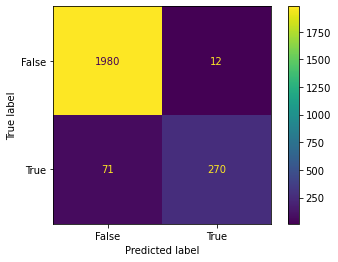

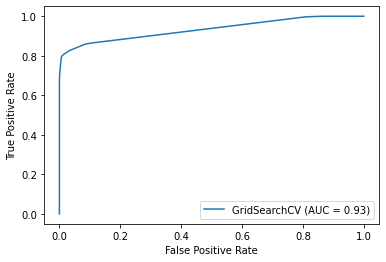

In [13]:
gs_model_results(model=GS_ord,X_train=X_train,y_train=y_train)

In [14]:
list(feature_importance_df.sort_values(by='feature importance',ascending=False).head(10).index)

NameError: name 'feature_importance_df' is not defined

### Decision Tree 2.0
- Limiting the total features used to 15 hurt our f1 score pretty signficantly
- Next we'll attempt to address the class imbalence using SMOTE on all the features
- If SMOTE is too computationally expensive on all the features, we can revert to limiting features

In [ ]:
#Create grid search grid locking max features at 10 or 15
param_grid_pipeline2 = {'estimator__criterion':['gini','entropy'],'estimator__max_depth':[None,5,6,7,8],'estimator__min_samples_leaf':[1,5,10],'estimator__max_features':[10,15]}

In [ ]:
#Instantiate a pipeline including the Decision Tree 2
DT_Pipeline_ord2 = Pipeline([
    ("CT",CT_ord),
    ("estimator",DecisionTreeClassifier(random_state=42))
])

#Fit our model
GS_ord2 = GridSearchCV(estimator=DT_Pipeline_ord2,param_grid=param_grid_pipeline2,scoring="f1_weighted",cv=5)
GS_ord2.fit(X=X_train,y=y_train)

#### Model evaluation

In [ ]:
#Best feature combination
GS_ord2.best_params_

In [ ]:
gs_model_results(model=GS_ord2,X_train=X_train,y_train=y_train)

### Decision Tree 3.0 with smote
- This is our best model
- Weighted avg f1 score: 0.94
- Slight improvement overall compared to model 1.0
- Importantly, I reduced the number of false negatives compared with model 1.0 which is very important for a churn model

#### Imports

In [15]:
#Import smote
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

#### Intantiate a imblearn version of our pipeline with SMOTE

In [16]:
#Instantiate a pipeline including SMOTE
#With Decision Tree
DT_Pipeline_smote = imbPipeline([
    ("CT",CT_ord),
    ("SMOTE",SMOTE(random_state=42)),
    ("estimator",DecisionTreeClassifier(random_state=42))
])

#### Grid search params

In [17]:
#Create grid search grid, instantiate grid search, and fit to train data
#Our baseline minority/majority is 17%. I want to increments up to a ratio of 42%
#Testing 3,5 and 10 k neighbors
param_grid_pipeline_smote = {'estimator__criterion':['gini','entropy'],
                       'estimator__max_depth':[None,5,6,7,8],
                       'estimator__min_samples_leaf':[1,5,10],
                       'SMOTE__sampling_strategy':[.30,.35,.42,.5],
                       'SMOTE__k_neighbors':[3,5,10]
                          }

#### Model fitting

In [18]:
#Fit our model
GS_smote = GridSearchCV(estimator=DT_Pipeline_smote,param_grid=param_grid_pipeline_smote,scoring="f1_weighted",cv=5)
GS_smote.fit(X=X_train,y=y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(transformers=[('num_columns',
                                                                         StandardScaler(),
                                                                         ['account '
                                                                          'length',
                                                                          'number '
                                                                          'vmail '
                                                                          'messages',
                                                                          'total '
                                                                          'day '
                                                                          'minutes',
                                                                          'total '
  

In [19]:
#Best feature combination
GS_smote.best_params_

{'SMOTE__k_neighbors': 3,
 'SMOTE__sampling_strategy': 0.35,
 'estimator__criterion': 'gini',
 'estimator__max_depth': 6,
 'estimator__min_samples_leaf': 5}

Weighted avg f1 score: 0.935

Split 1 f1 score: 0.949
Split 2 f1 score: 0.938
Split 3 f1 score: 0.917
Split 4 f1 score: 0.925
Split 5 f1 score: 0.948


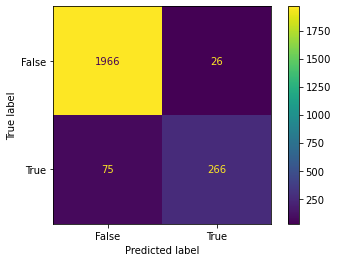

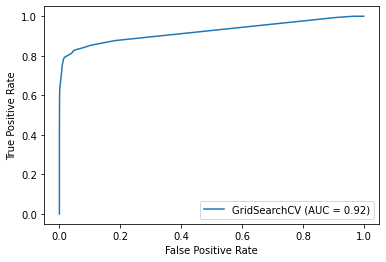

In [20]:
gs_model_results(model=GS_smote,X_train=X_train,y_train=y_train)

### Evaluating final model

In [21]:
#Save our best model from modeling 3.0
best_estimator = GS_smote.best_estimator_.named_steps.estimator
#Create a best model pipeline
best_model_pipeline = imbPipeline([
    ("CT",CT_ord),
    ("SMOTE",GS_smote.best_estimator_.named_steps.SMOTE),
    ("estimator",best_estimator)
])

In [22]:
#Fit our into our pipeline on the training data
best_model_pipeline.fit(X=X_train,y=y_train)

Pipeline(steps=[('CT',
                 ColumnTransformer(transformers=[('num_columns',
                                                  StandardScaler(),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
                                                   'total night minutes',
                                                   'total night calls',
                                                   'total night charge',
                                                   'to

In [23]:
best_model_pipeline.score(X=X_test,y=y_test)

0.94

In [29]:
#define a function to score our model on test data
def test_results(model,X_test,y_test):
    plot_confusion_matrix(estimator=model,X=X_test,y_true=y_test)
    plot_roc_curve(estimator=model,X=X_test,y=y_test)
    print(f' F1 Score: {f1_score(y_true=y_test,y_pred=(model.predict(X=X_test)))}')
    print(f' Precision Score: {precision_score(y_true=y_test,y_pred=(model.predict(X=X_test)))}')

 F1 Score: 0.7810218978102189
 Precision Score: 0.8106060606060606


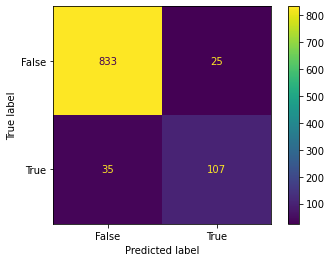

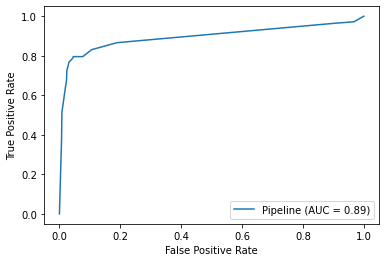

In [30]:
test_results(model=best_model_pipeline,X_test=X_test,y_test=y_test)